In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps


import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torchvision.datasets import CIFAR10, MNIST

In [97]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

root = "~/datasets/MNIST/"

train_dataset = MNIST(root, download=True, train=True)
test_dataset = MNIST(root, download=True, train=False)

In [98]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [99]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.dataset)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.dataset) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.dataset) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = img0_tuple[0]
        img1 = img1_tuple[0]

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.dataset.data)

In [100]:
siamese_dataset = SiameseNetworkDataset(dataset=train_dataset, transform=transform)

In [101]:
len(siamese_dataset)

60000

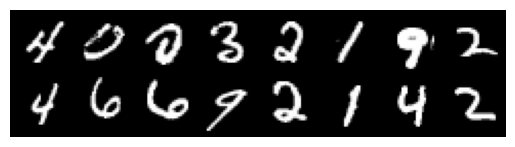

[0. 1. 1. 1. 0. 0. 1. 0.]


In [102]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [114]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=5,stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(1536, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [115]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [116]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

In [117]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [124]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(10):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 100 == 0 :
            print(f"{i} Epoch number {epoch}, Current loss {loss_contrastive.item()}")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

0 Epoch number 0, Current loss 0.023504767566919327
100 Epoch number 0, Current loss 0.009144251234829426
200 Epoch number 0, Current loss 0.008569530211389065
300 Epoch number 0, Current loss 0.028644539415836334
400 Epoch number 0, Current loss 0.033044032752513885
500 Epoch number 0, Current loss 0.009618990123271942
600 Epoch number 0, Current loss 0.021617455407977104
700 Epoch number 0, Current loss 0.01824105530977249
800 Epoch number 0, Current loss 0.015874747186899185
900 Epoch number 0, Current loss 0.018492557108402252
0 Epoch number 1, Current loss 0.007820826023817062
100 Epoch number 1, Current loss 0.006939837709069252
200 Epoch number 1, Current loss 0.031005393713712692
300 Epoch number 1, Current loss 0.007328561972826719
400 Epoch number 1, Current loss 0.055826585739851
500 Epoch number 1, Current loss 0.017420560121536255
600 Epoch number 1, Current loss 0.011629645712673664
700 Epoch number 1, Current loss 0.009851190261542797
800 Epoch number 1, Current loss 0.0

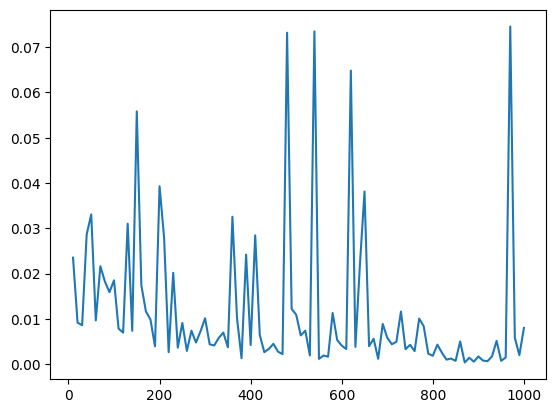

In [125]:
show_plot(counter, loss_history)

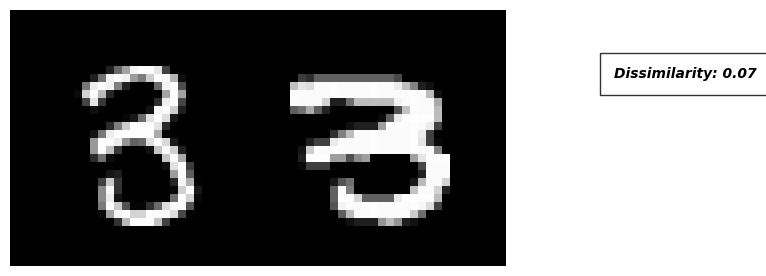

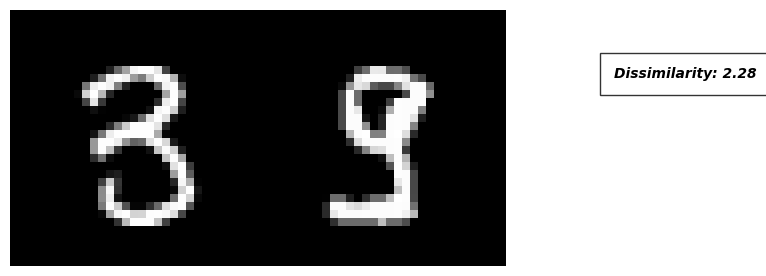

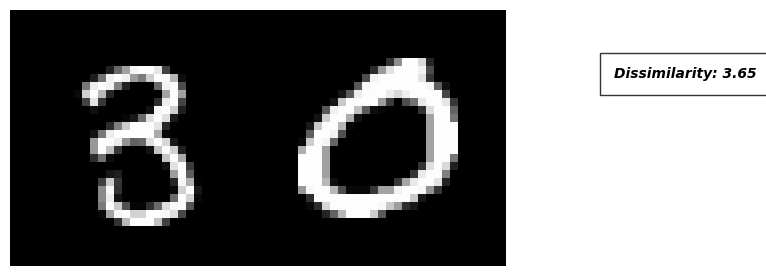

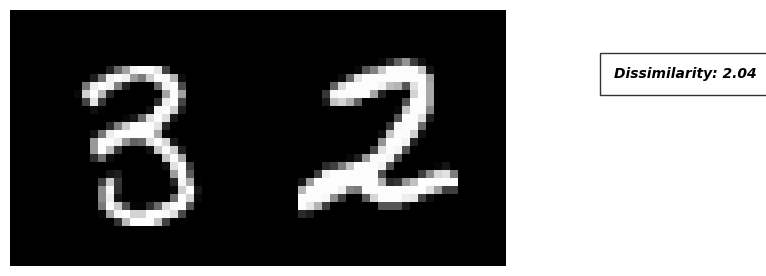

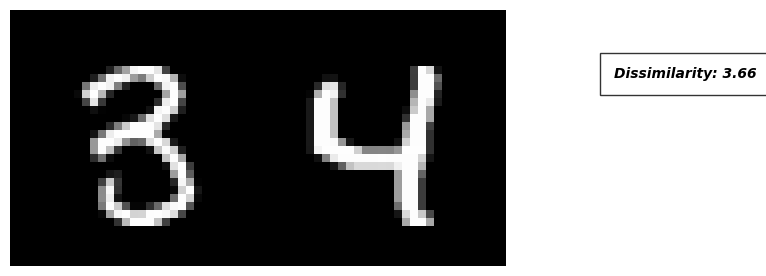

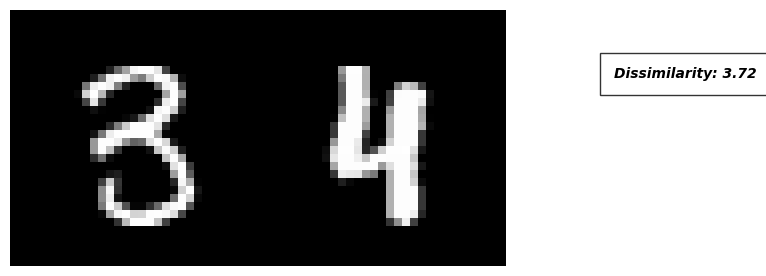

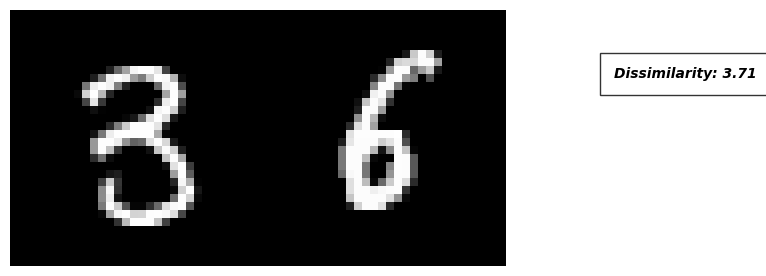

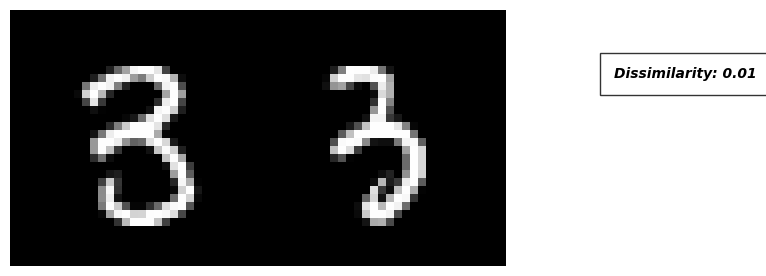

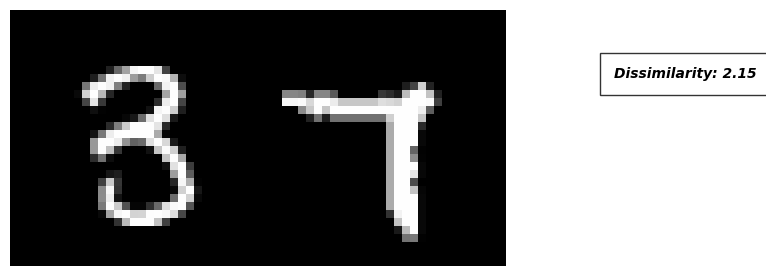

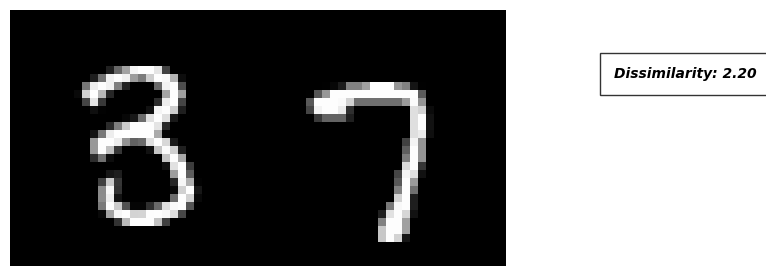

In [129]:
# Locate the test dataset and load it into the SiameseNetworkDataset
# folder_dataset_test = datasets.ImageFolder(root="Celebrity Faces Dataset/Test/")
siamese_dataset = SiameseNetworkDataset(dataset=test_dataset, transform=transform)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
#     print(output1, output2)